# A Compartmental Model Utilising Reinforcement Learning to Guide Country-Specific Vaccination Prioritisation 

In [1]:
# Importing libraries:

#gym is used for creating an environment for RL
from gym import Env
from gym.envs.registration import EnvSpec
from gym.spaces import MultiDiscrete,Box

#numerical methods library
import numpy as np

#graph_tool for graphs (with vertices and edges)
from graph_tool.all import *

#RL library
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

#extern file which creates a graph and defines helper functions operating on graph
from makegraph import *

#library for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def simulatepandemic(self,actions):
    if(np.sum(actions) != 0):
        #relative availability of vaccine is calculated
        actions = np.divide(actions,np.sum(actions)) 
    actions = np.multiply(actions,self.vacc_sum)
    if self.timestep == 0:
        vacc_pop = update_firststate(self.g,actions)
    else:
        vacc_pop = update_state(self.g,actions)
    erate = extract_economy(self.g)
    self.state = graph_to_matrix(self.g)
    self.timestep += 1
    self.vacc_pop = np.add(self.vacc_pop,vacc_pop)
    return self.state,erate

def initializepandemic(self):
    self.g = make_graph(self.size,self.distribution)
    self.state = graph_to_matrix(self.g)
    return self.state

In [3]:

class PanEnv(Env):
    def __init__(self,size,distribution):
        self.size = size #original population size
        self.spec = EnvSpec('GymEnv-v0')
        self.action_space = MultiDiscrete(nvec=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10])
        self.observation_space = Box(low=-np.inf,high=np.inf,shape=[self.size,7])
        
        #age distribution, country name as string
        self.distribution = distribution 
        
        #create a graph using distribution
        self.g = make_graph(self.size,self.distribution)
        
        #available vaccines per timestep for all age groups
        self.vacc_sum = 1*round(size/20) 
        
        #keeps track of how many people per age group are vaccinated
        self.vacc_pop = np.zeros(20) 
                
        #state observation as matrix: each line corresponds to one individual, the first 6 columns represent
        #the states with a one in the column of the individual's current state. The last column tracks economy
        self.state = graph_to_matrix(self.g)
        
        self.timestep = 0
        
    def step(self,actions):
    
        result = simulatepandemic(self,actions)
        
        state = result[0]

        #economy value
        E_t = result[1]

        total_population = self.size

        #death rate
        D_t = np.sum(state[:,5])/total_population
        
        
        reward = E_t/total_population - 2*D_t

        done = False
        
        if((self.timestep > 50) or np.sum(self.state[:,1])==0):
            done = True
        
        info = {}
        
        return state, reward, done, info
    
    def reset(self):
        #returns initial state
        self.timestep = 0
        self.state = initializepandemic(self)
        self.vacc_pop = np.zeros(20)
        return self.state

In [4]:
#importing PPO for learning
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

#tensorflow for graphs during the learning (e.g tracking mean reward)
import tensorflow as tf

2021-12-05 14:22:20.310186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-05 14:22:20.310251: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Here the actual learning happens, after learning we save our model, so we can use it later, the best trained model is stored in final.zip and will be loaded in the next cells

In [ ]:
# Parallel environments
env = DummyVecEnv([lambda: Monitor(PanEnv(size=1000,distribution='Japan'),log_dir)])

In [ ]:
#the model will learn for 25K steps, information (e.g mean reward and episode length will be logged onto tensorboard with the name first_run
odel.learn(total_timesteps=25000,tb_log_name="first_run") #training loop

In [ ]:
#Save the model after learning 
model.save("Model_name")

# Model benchmark. Here we used the trained model on new environments using predict function.

In [ ]:
#size of the population
size = 1000

#Japan:
obs_storage_J = []
rewards_storage_J = []
action_storage_J = []
vacc_J = []
#Niger
obs_storage_N = []
rewards_storage_N = []
action_storage_N = []
vacc_N = []
#Switzerland
obs_storage_S = []
rewards_storage_S = []
action_storage_S = []
vacc_S = []
#load the model from final (well-trained)
Model_name = PPO.load("final")

#Environments for prediction
env_J = PanEnv(size=size,distribution='Japan')
env_N = PanEnv(size=size,distribution='Niger')
env_S = PanEnv(size=size,distribution='Switzerland')

#reset observations
obs_J = env_J.reset()
obs_N = env_N.reset()
obs_S = env_S.reset()

In [ ]:
#Japan prediction
done = False

#dictionaries for tracking average states and vacc for 100 episodes (only for Japan)
J_states = {}
J_vacc = {}

#dead people in every age group (20 age groups)
ded = np.zeros(20)

#predict Japan for 100 times to calculate average values
for i in np.arange(1,101):
    
    #resetting for every iteration
    vacc_J = []
    done = False
    obs_J = env_J.reset()
    obs_storage_J = []
    
    #prediction
    while not done:
       
        action, _states = Model_name.predict(obs_J)
        
        vacc_J.append(env_J.vacc_pop)
        obs_storage_J.append(obs_J)
        
        obs_J, rewards, done, info = env_J.step(action)
        
        infected = np.nonzero(obs_J[:,1])
        
        rewards_storage_J.append(rewards)
        action_storage_J.append(action)
        
    vacc_J.append(env_J.vacc_pop)
    obs_storage_J.append(obs_J)
    
    #little converting trick
    vacc_J = np.divide(vacc_J,1)
    
    J_states[i] = obs_storage_J
    J_vacc[i] = vacc_J
    
    #counting dead people
    vs = env_J.g.vertices()
    for v in vs:
        if env_J.g.vp.state[v] == [0.8, 0, 0, 0.6]:
            ded[env_J.g.vp.age[v]-1] += 1
            
#trick    
ded = np.divide(ded,100)

In [ ]:
#Niger prediction
done = False

while not done:
    action, _states = Model_name.predict(obs_N)
    
    vacc_N.append(env_N.vacc_pop)
    obs_storage_N.append(obs_N)
    obs_N, rewards, done, info = env_N.step(action)
    
    infected = np.nonzero(obs_N[:,1])
    l=np.size(infected)/size
    rewards_storage_N.append(rewards)
    action_storage_N.append(action)
vacc_N.append(env_N.vacc_pop)
vacc_N = np.divide(vacc_N,1)
obs_storage_N.append(obs_N)

In [ ]:
#Switzerland prediction
done = False

while not done:
    action, _states = Model_name.predict(obs_S)
    
    vacc_S.append(env_S.vacc_pop)
    obs_storage_S.append(obs_S)
    obs_S, rewards, done, info = env_S.step(action)
    
    infected = np.nonzero(obs_S[:,1])
    l=np.size(infected)/size
    rewards_storage_S.append(rewards)
    action_storage_S.append(action)
vacc_S.append(env_S.vacc_pop)
vacc_S = np.divide(vacc_S,1)
obs_storage_S.append(obs_S)

In [13]:

#plotting helpers

cmap = mpl.cm.get_cmap('tab20')
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)
mpl.rcParams.update({'font.size': 14})
    
def get_sums(obs,index):
    sums = []
    for i in np.arange(0,len(obs)):
        sums.append(np.sum(obs[i][:,index]))
    return sums
def show_pandemic(obs,country):
    all_sums = []
    for i in np.arange(0,7):
        all_sums.append(get_sums(obs,i))
    sval,ival,rval,vsval,vival,dval,economy_list = all_sums[0],all_sums[1],all_sums[2],all_sums[3],all_sums[4],all_sums[5],all_sums[6]
    tlist = np.arange(0,len(obs))
    
    color_pos = np.linspace(0,1,7)
    colors = [cmap(pos) for pos in color_pos]
    
    plt.figure(figsize=(9,6))
    plt.title('Pandemic development: '+country)
    plt.plot(tlist, sval, label = "S",color=colors[0])
    plt.plot(tlist, rval, label = "R",color=colors[1])
    plt.plot(tlist, vsval, label = "Sv",color=colors[2])
    plt.plot(tlist, vival, label = "Iv",color=colors[3])
    plt.plot(tlist, ival, label = "I",color=colors[4])
    plt.plot(tlist, dval, label = "D",color=colors[5])
    plt.plot(tlist,economy_list, label = "Economy",color=colors[6])
    ax = plt.gca()
    ax.set_xticks(tlist)
    ax.set_xticklabels(np.multiply(tlist,20))
    plt.ylabel('People per state')
    plt.xlabel('Days')
    plt.legend(loc='upper right',prop={'size': 10})
    plt.show()
    
def show_actions(actions):
    eps = len(actions)
    
    color_pos = np.linspace(0,1,eps)
    cmap = mpl.cm.get_cmap('inferno')
    colors = [cmap(pos) for pos in color_pos]
    plt.figure()
    
    for i in np.arange(0,eps):
        #hist = np.histogram(actions[i],bins = np.linspace(1,21,20))
        plt.plot(np.linspace(1,21,20),actions[i]/np.sum(actions[i]),color=colors[i],label='t = str(i)')
    plt.show()

def count_deaths(g):
    
    ded=[]
    for i in range(20):
        ded.append(0)
    vs = g.vertices()
    
    for v in vs:
        if g.vp.state[v] == [0.8, 0, 0, 0.6]:
            ded[g.vp.age[v]-1] += 1
    return ded
def show_death(ded_J,ded_N,ded_S):
    color_pos = np.linspace(0,1,3)
    colors = [cmap(pos) for pos in color_pos]
    plt.figure(figsize=(9,6))
    plt.title('Average deaths by age group')
    plt.bar(np.linspace(1,20,20), ded_J, align = 'edge',color=colors[0],label='Japan')
    plt.bar(np.linspace(1,20,20), ded_S, align = 'edge',color=colors[1],label='Switzerland')
    plt.bar(np.linspace(1,20,20), ded_N, align = 'edge',color=colors[2],label='Niger')
    ax = plt.gca()
    ax.set_xticks(np.arange(1,21))
    ax.set_xticklabels(np.multiply(np.arange(0,20),5))
    plt.ylabel('People')
    plt.xlabel('Age group')
    plt.legend()
    plt.show()

#takes as input vaccines per age group per timestep
def show_vaccines(vaccmatrix,g,country):
    tlist = np.arange(0,len(vaccmatrix))
    
    color_pos = np.linspace(0,1,20)
    colors = [cmap(pos) for pos in color_pos]
    
    ages = get_ages(g)
    agelabels = np.multiply(np.arange(0,20),5)
    
    plt.figure(figsize=(9,6))
    plt.title('Vaccinated population per age group over time: '+country)
    for i in np.arange(0,20):
        vacc = np.divide(vaccmatrix[:,i],ages[i])
        plt.plot(tlist,vacc,label=agelabels[i],color=colors[i])
    ax = plt.gca()
    ax.set_xticks(tlist)
    ax.set_xticklabels(np.multiply(tlist,20))
    plt.ylabel('Percentage of vaccinated people')
    plt.xlabel('Days')
    plt.legend(loc='upper right',prop={'size': 10})
    plt.show()
    
def actions_to_matrix(actions):
    matrix = np.zeros([len(actions), 20])
    for i in range(len(actions)):
        for j in range(20):
            matrix[i][j] = actions[i][j]
    return matrix



# Plotting:

In [ ]:
show_pandemic(obs_storage_J,"Japan")
show_pandemic(obs_storage_N,"Niger")
show_pandemic(obs_storage_S,"Switzerland")
show_vaccines(vacc_J,env_J.g,"Japan")
show_vaccines(vacc_N,env_N.g,"Niger")
show_vaccines(vacc_S,env_S.g,"Switzerland")
show_death(count_deaths(env_J.g),count_deaths(env_N.g),count_deaths(env_S.g))


# Modelling with fixed policy, no RL:

In [5]:
test_env_J = PanEnv(size=1000,distribution='Japan')
test_env_S = PanEnv(size=1000,distribution='Switzerland')
test_env_N = PanEnv(size=1000,distribution='Niger')

#define fixed policy: distribute all vaccines evenly for population >65 years
action_ = [0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,10,10,10]
#define policy for no vaccines
noaction = np.zeros(20)

In [7]:
J_states = {}
J_rewards = {}
J_vacc = {}
S_states = {}
S_rewards = {}
S_vacc = {}
N_states = {}
N_rewards = {}
N_vacc = {}

In [8]:
#this function repeatedly applies one action to an environment, repeats that for [runs] amount of epochs and
#stores the results
#the 'ded' it returns gives the average number of dead people at the end of each epoch, used for the histogram
def simulate_fixedaction(environment,action,runs,statesdict,rewardsdict,vaccdict):
    ded = np.zeros(20)
    for k in np.arange(1,runs+1):
        states = [environment.state]
        rewards = []
        vaccs = [environment.vacc_pop]
        done = False
        while not done:
            state, reward, done, _ = environment.step(action)
            #print(environment.timestep,k)
            states.append(state)
            rewards.append(reward)
            vaccs.append(environment.vacc_pop)
        vaccdict[k] = vaccs
        statesdict[k] = states
        rewardsdict[k] = rewards
        vs = environment.g.vertices()
        for v in vs:
            if environment.g.vp.state[v] == [0.8, 0, 0, 0.6]:
                ded[environment.g.vp.age[v]-1] += 1
        environment.reset()
    ded = np.divide(ded,runs)
    return ded

#calculates mean amount of dead people per epoch
def get_meandead(statesdict):
    ded = np.zeros(len(statesdict))
    for k in np.arange(1,len(statesdict)+1):
        runs = len(statesdict[k])
        ded[k-1] = np.sum(statesdict[k][runs-1][:,5])
        #print(ded[k-1])
    return np.mean(ded),np.std(ded)

#calculates mean amount of infected people per epoch
def get_meaninf(statesdict):
    inf = np.zeros(len(statesdict))
    for k in np.arange(1,len(statesdict)+1):
        runs = len(statesdict[k])
        #to find the sum of people that were infected over one epoch, we count dead, recovered and infected
        #individuals for the final state
        inf[k-1] = np.sum(statesdict[k][runs-1][:,5]) + np.sum(statesdict[k][runs-1][:,2])
        inf[k-1] += np.sum(statesdict[k][runs-1][:,1]) + np.sum(statesdict[k][runs-1][:,4])
        #print(ded[k-1])
    return np.mean(inf),np.std(inf)

#from all the runs, this generates how the observation matrix for an average epoch looks per time step
def get_meanobs(statesdict):
    obs = []
    for t in np.arange(0,5):
        state = np.zeros((len(statesdict[1][0][:,0]),7))
        for k in np.arange(1,len(statesdict)+1):
            if t < len(statesdict[k]):
                state = np.add(state,statesdict[k][t])
        obs.append(state)
    return np.divide(obs,len(statesdict))

#calculates average amount of vaccinated people per age group per time step
def get_meanvaccs(vaccdict):
    vaccs = []
    for t in np.arange(0,5):
        vacc = np.zeros(20)
        for k in np.arange(1,len(vaccdict)+1):
            if t < len(vaccdict[k]):
                vacc = np.add(vacc,vaccdict[k][t])
        vaccs.append(vacc)
    return np.divide(vaccs,len(vaccdict))

In [9]:
J_deadbyage = simulate_fixedaction(test_env_J,noaction,100,J_states,J_rewards,J_vacc)
S_deadbyage = simulate_fixedaction(test_env_S,noaction,100,S_states,S_rewards,S_vacc)
N_deadbyage = simulate_fixedaction(test_env_N,noaction,100,N_states,N_rewards,N_vacc)

In [10]:
J_dead = get_meandead(J_states)
S_dead = get_meandead(S_states)
N_dead = get_meandead(N_states)

print(f" Japan mean dead:{J_dead[0]:.2f} +/- {J_dead[1]:.2f}")
print(f" Niger mean dead:{N_dead[0]:.2f} +/- {N_dead[1]:.2f}")
print(f" Switzerland mean dead:{S_dead[0]:.2f} +/- {S_dead[1]:.2f}")

 Japan mean dead:73.80 +/- 7.45
 Niger mean dead:8.52 +/- 3.19
 Switzerland mean dead:51.16 +/- 7.04


In [11]:
J_inf = get_meaninf(J_states)
S_inf = get_meaninf(S_states)
N_inf = get_meaninf(N_states)

print(f" Japan mean infected:{J_inf[0]:.2f} +/- {J_inf[1]:.2f}")
print(f" Niger mean infected:{N_inf[0]:.2f} +/- {N_inf[1]:.2f}")
print(f" Switzerland mean infected:{S_inf[0]:.2f} +/- {S_inf[1]:.2f}")

 Japan mean infected:930.61 +/- 9.77
 Niger mean infected:843.21 +/- 120.68
 Switzerland mean infected:927.00 +/- 9.73


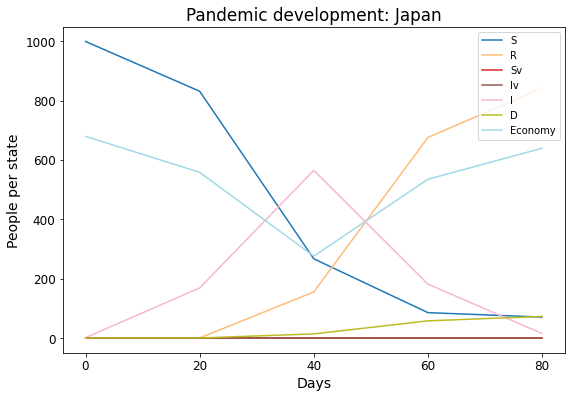

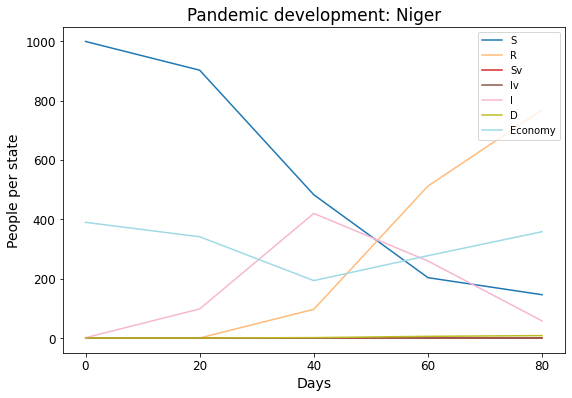

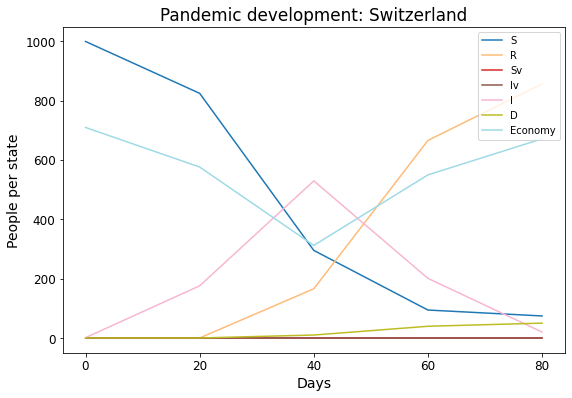

In [14]:
show_pandemic(get_meanobs(J_states),'Japan')
show_pandemic(get_meanobs(N_states),'Niger')
show_pandemic(get_meanobs(S_states),'Switzerland')

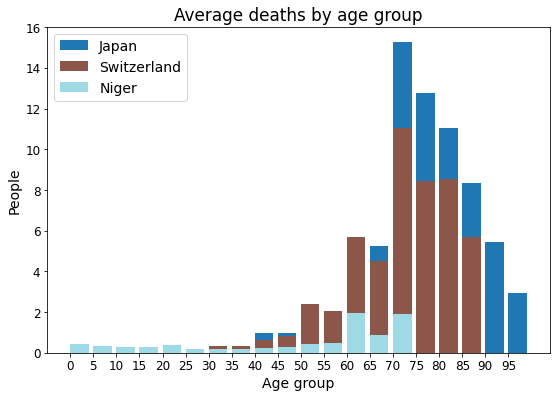

In [16]:
color_pos = np.linspace(0,1,3)
colors = [cmap(pos) for pos in color_pos]
plt.figure(figsize=(9,6))
plt.title('Average deaths by age group')
plt.bar(np.linspace(1,20,20), J_deadbyage, align = 'edge',color=colors[0],label='Japan')
plt.bar(np.linspace(1,20,20), S_deadbyage, align = 'edge',color=colors[1],label='Switzerland')
plt.bar(np.linspace(1,20,20), N_deadbyage, align = 'edge',color=colors[2],label='Niger')
ax = plt.gca()
ax.set_xticks(np.arange(1,21))
ax.set_xticklabels(np.multiply(np.arange(0,20),5))
plt.ylabel('People')
plt.xlabel('Age group')
plt.legend()
plt.show()

In [ ]:
show_vaccines(get_meanvaccs(J_vacc),test_env_J.g,'Japan')
show_vaccines(get_meanvaccs(N_vacc),test_env_J.g,'Niger')
show_vaccines(get_meanvaccs(S_vacc),test_env_J.g,'Switzerland')